In [1]:
import pennylane as qml
from pennylane import numpy as np
from functools import partial

dev = qml.device("alicebob.qubit", alice_backend="EMU:40Q:LOGICAL_TARGET", wires=2, average_nb_photons=160, kappa_1=10, kappa_2=1e8)
#dev = qml.device("alicebob.qubit", alice_backend="EMU:40Q:LOGICAL_TARGET", wires=3, average_nb_photons=4, kappa_2=1e4)
#dev = qml.device("default.qubit", wires=2)

@partial(qml.cut_circuit, auto_cutter=True)  # auto_cutter enabled
@qml.qnode(dev)
def circuit(x):
    qml.RX(x, wires=0)
    qml.RY(0.9, wires=1)
    qml.RX(0.3, wires=2)

    qml.CZ(wires=[0, 1])
    qml.RY(-0.4, wires=0)

    qml.CZ(wires=[1, 2])

    return qml.expval(qml.pauli.string_to_pauli_word("ZZZ"))


x = np.array(0.531, requires_grad=True)
circuit(x)
#qml.draw_mpl(circuit)(x)

Using alice & bob EMU:40Q:LOGICAL_TARGET backend...


/usr/local/python/3.11.8/lib/python3.11/site-packages/qiskit/synthesis/discrete_basis/generate_basis_approximations.py:61: RuntimeWarning: The SolovayKitaev algorithm relies on scikit-learn's KDTree for a fast search over the basis approximations. Without this, we fallback onto a greedy search with is significantly slower. We highly suggest to install scikit-learn to use this feature.
  warnings.warn(


0.5260772705078126

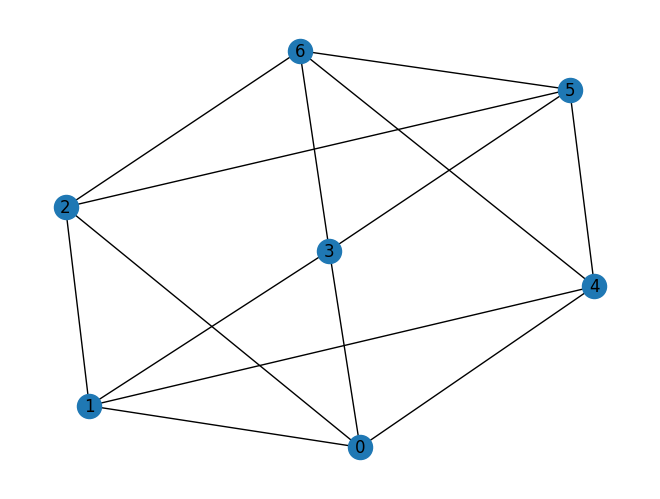

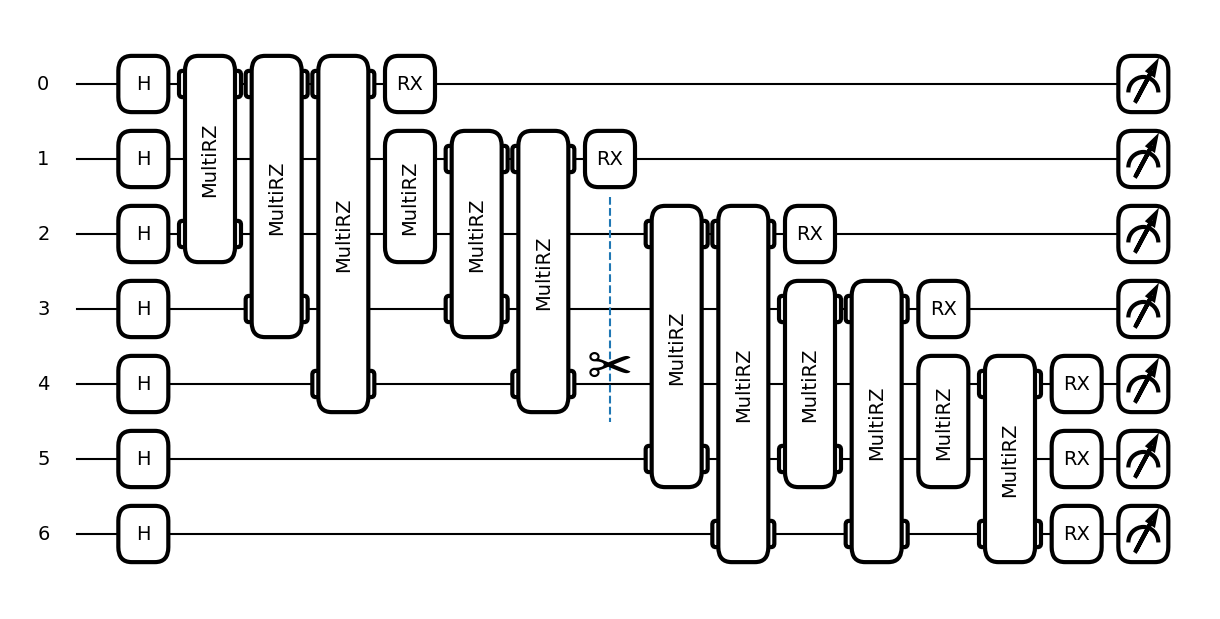

In [3]:
import networkx as nx
from itertools import product, combinations
from pennylane import numpy as np
import pennylane as qml

np.random.seed(1337)

n_side_nodes = 2
n_middle_nodes = 3

top_nodes = range(0, n_side_nodes)
middle_nodes = range(n_side_nodes, n_side_nodes + n_middle_nodes)
bottom_nodes = range(n_side_nodes + n_middle_nodes, n_middle_nodes + 2 * n_side_nodes)

top_edges = list(product(top_nodes, middle_nodes))
bottom_edges = list(product(middle_nodes, bottom_nodes))

graph = nx.Graph()
graph.add_edges_from(combinations(top_nodes, 2), color=0)
graph.add_edges_from(top_edges, color=0)
graph.add_edges_from(bottom_edges, color=1)
graph.add_edges_from(combinations(bottom_nodes, 2), color=1)

nx.draw_spring(graph, with_labels=True)

def qaoa_cost(bitstring):

    bitstring = np.atleast_2d(bitstring)
    # Make sure that we operate correctly on a batch of bitstrings

    z = (-1) ** bitstring[:, graph.edges()]  # Filter out pairs of bits correspondimg to graph edges
    costs = z.prod(axis=-1).sum(axis=-1)  # Do products and sums
    return np.squeeze(costs) / len(graph.edges)  # Normalize


def qaoa_template(params):

    gamma, beta = params

    for i in range(len(graph)):  # Apply the Hadamard gates
        qml.Hadamard(wires=i)

    for i, j in top_edges:

        # Apply the ZZ rotation gates
        # corresponding to the
        # green edges in the figure

        qml.MultiRZ(2 * gamma, wires=[i, j])

    qml.WireCut(wires=middle_nodes)  # Place the wire cut

    for i, j in bottom_edges:

        # Apply the ZZ rotation gates
        # corresponding to the
        # purple edges in the figure

        qml.MultiRZ(2 * gamma, wires=[i, j])

    for i in graph.nodes():  # Finally, apply the RX gates
        qml.RX(2 * beta, wires=i)

from pennylane.tape import QuantumTape

optimal_params = np.array([-0.240, 0.327])
optimal_cost = -0.248

all_wires = list(range(len(graph)))

with qml.queuing.AnnotatedQueue() as q:
    qaoa_template(optimal_params)
    qml.sample(wires=all_wires)

tape = QuantumTape.from_queue(q)

fig, _ = qml.drawer.tape_mpl(tape)
fig.set_size_inches(12, 6)

Probability of measuring each state: [0.228, 0.265, 0.243, 0.264]


<BarContainer object of 4 artists>

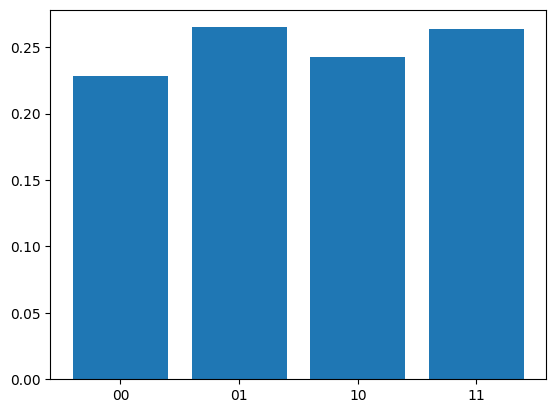

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import product, combinations
from pennylane import numpy as np
import pennylane as qml

n_qubit = 2

dev = qml.device("default.qubit", wires=3, shots=1000)
#dev = qml.device("alicebob.qubit", alice_backend="EMU:15Q:LOGICAL_EARLY", wires=2, average_nb_photons=4, kappa_2=1e4, shots=100)
#dev = qml.device("alicebob.qubit", alice_backend="EMU:40Q:LOGICAL_TARGET", wires=3, average_nb_photons=4, kappa_2=1e4)

@qml.cut_circuit_mc
@qml.qnode(dev)
def circuit():
    qml.Hadamard(0)
    qml.CNOT(wires=[0, 1])
    qml.WireCut(wires=2)

    return qml.sample(wires=[0,1])

res = circuit()

# calculate the probability of measuring all the states
#bitstrings = ["{0:03b}".format(i) for i in range(2**3)]

# bitstrings but take into account the n_qubit number
bitstrings = ["{0:0{1}b}".format(i, n_qubit) for i in range(2**n_qubit)]


probs = []

str_res = []

for r in res:
    str_res.append("".join([str(int(i)) for i in r]))

for b in bitstrings:
    probs.append(str_res.count(b) / len(res))

print(f"Probability of measuring each state: {probs}")
plt.bar(bitstrings, probs)

In [230]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import product, combinations
from pennylane import numpy as np
import pennylane as qml

n_qubit = 2

dev = qml.device("default.qubit", wires=3, shots=100)
#dev = qml.device("alicebob.qubit", alice_backend="EMU:15Q:LOGICAL_EARLY", wires=3, average_nb_photons=4, kappa_2=1e4, shots=100)
#dev = qml.device("alicebob.qubit", alice_backend="EMU:40Q:LOGICAL_TARGET", wires=3, average_nb_photons=4, kappa_2=1e4)

@qml.cut_circuit_mc
@qml.qnode(dev)
def circuit():
    qml.Hadamard(0)
    qml.CNOT(wires=[0, 1])
    #qml.Hadamard(2)
    #qml.CNOT(wires=[0, 1])
    qml.WireCut(wires=2)


    return qml.sample(wires=[0,1])

res = circuit()

# calculate the probability of measuring all the states
bitstrings = ["{0:03b}".format(i) for i in range(2**3)]

print(f"Expectation value: {res}")

#qml.draw_mpl(circuit)()

Expectation value: [[0. 1.]
 [1. 0.]
 [0. 0.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 1.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 0.]
 [1. 1.]
 [1. 0.]
 [0. 0.]
 [0. 1.]
 [1. 1.]
 [0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 0.]
 [1. 0.]]


(<Figure size 500x400 with 1 Axes>, <Axes: >)

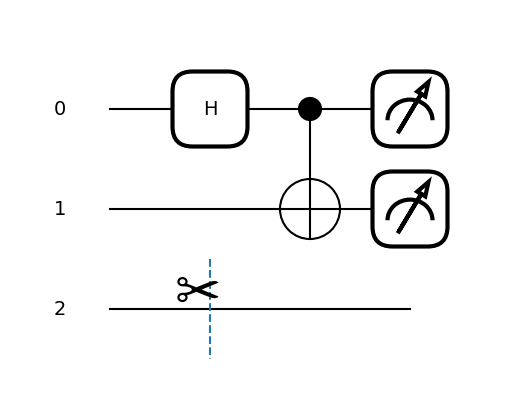

In [87]:
qml.draw_mpl(circuit)()

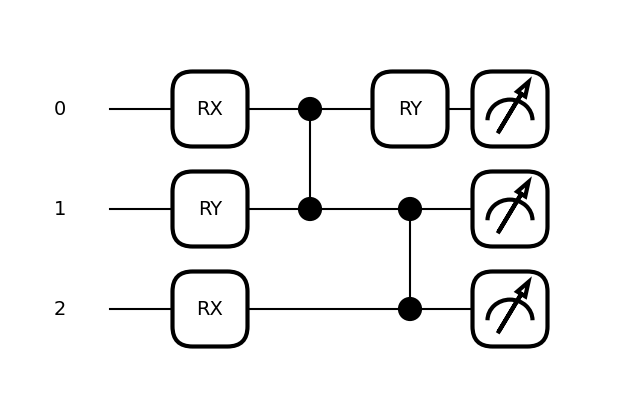

In [88]:
# Import the relevant libraries
from functools import partial

import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=3)


@qml.qnode(dev)
def circuit(x):
    qml.RX(x, wires=0)
    qml.RY(0.9, wires=1)
    qml.RX(0.3, wires=2)

    qml.CZ(wires=[0, 1])
    qml.RY(-0.4, wires=0)

    qml.CZ(wires=[1, 2])

    return qml.expval(qml.pauli.string_to_pauli_word("ZZZ"))


x = np.array(0.531, requires_grad=True)
fig, ax = qml.draw_mpl(circuit)(x)

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qcut
from pennylane.wires import Wires


def fn(x):
    """
    Classical processing function for MC circuit cutting
    """
    if x[0] == 0 and x[1] == 0:
        return 1
    if x[0] == 0 and x[1] == 1:
        return -1
    if x[0] == 1 and x[1] == 0:
        return -1
    if x[0] == 1 and x[1] == 1:
        return 1

dev_sim = qml.device("default.qubit", wires=3)

@qml.qnode(dev_sim)
def target_circuit(v):
    qml.RX(v, wires=0)
    qml.RY(0.5, wires=1)
    qml.RX(1.3, wires=2)

    qml.CNOT(wires=[0, 1])
    qml.WireCut(wires=1)
    qml.CNOT(wires=[1, 2])

    qml.RX(v, wires=0)
    qml.RY(0.7, wires=1)
    qml.RX(2.3, wires=2)
    return qml.expval(qml.PauliZ(wires=0) @ qml.PauliZ(wires=2))

dev = qml.device("default.qubit", wires=2, shots=10000)

@qml.cut_circuit_mc(fn)
@qml.qnode(dev)
def circuit(v):
    qml.RX(v, wires=0)
    qml.RY(0.5, wires=1)
    qml.RX(1.3, wires=2)

    qml.CNOT(wires=[0, 1])
    qml.WireCut(wires=1)
    qml.CNOT(wires=[1, 2])

    qml.RX(v, wires=0)
    qml.RY(0.7, wires=1)
    qml.RX(2.3, wires=2)
    return qml.sample(wires=[0, 2])

v = 0.319
cut_res_mc = circuit(v)

target = target_circuit(v)

print(f"Original circuit: {target}")
print(f"Cut circuit: {cut_res_mc}")

assert np.isclose(cut_res_mc, target, atol=0.1)



TypeError: 'QNode' object is not subscriptable

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import product, combinations
from pennylane import numpy as np
import pennylane as qml

n_qubit = 2

dev = qml.device("default.qubit", wires=2, shots=1000)

def fn(x):
    """
    Classical processing function for MC circuit cutting
    """
    if x[0] == 0 and x[1] == 0:
        return 1
    if x[0] == 0 and x[1] == 1:
        return -1
    if x[0] == 1 and x[1] == 0:
        return -1
    if x[0] == 1 and x[1] == 1:
        return 1

@qml.cut_circuit_mc(fn)
@qml.qnode(dev)
def circuit():
    qml.Hadamard(0)
    qml.Hadamard(1)
    qml.CZ(wires=[0, 1])
    qml.Hadamard(1)
    qml.WireCut(wires=2)

    return qml.sample(wires=[0,1])

res = circuit()

bitstrings = ["{0:0{1}b}".format(i, n_qubit) for i in range(2**n_qubit)]


probs = []

str_res = []

for r in res:
    str_res.append("".join([str(int(i)) for i in r]))

for b in bitstrings:
    probs.append(str_res.count(b) / len(res))

print(f"Probability of measuring each state: {probs}")
plt.bar(bitstrings, probs)

<QNode: device='<default.qubit device (wires=2, shots=1000) at 0x7eff94d98690>', interface='auto', diff_method='best'>


TypeError: 'QNode' object is not subscriptable